# SHAP - Linear regression

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll use the approximation of Shapley values that is suitable for linear models.

This approximation is **model specific** and will be used when you want to explain a linear models.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import shap

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns = ["Latitude", "Longitude", "AveBedrms"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0,
)

# Scale data
scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Linear regression

In [3]:
linreg = LinearRegression().fit(X_train, y_train)

preds = linreg.predict(X_test)

preds

array([2.07007444, 2.96469595, 2.27789975, ..., 3.81071816, 1.29678525,
       2.48722002])

In [4]:
# performance

linreg.score(X_test, y_test)

0.4914863579707852

In [5]:
# coefficients of the linear regression

coeffs = pd.Series(linreg.coef_, index=linreg.feature_names_in_)
coeffs

MedInc        6.569900
HouseAge      0.880922
AveRooms     -4.967091
Population    0.832171
AveOccup     -3.642405
dtype: float64

## Feature effects

Let's take an individual observation and evaluate how its feature values contribute towards house price. This is given by the feature's values times the coefficients.

In [6]:
# reset index so we can compare with outpuf of SHAP later

X_test.reset_index(inplace=True, drop=True)

In [7]:
# we'll explain one observations from this view

X_test.tail()

,MedInc,HouseAge,AveRooms,Population,AveOccup
6187,0.179053,0.686275,0.029618,0.032652,0.002736
6188,0.250941,0.019608,0.060561,0.079122,0.004371
6189,0.508621,0.568627,0.050914,0.014574,0.002790
6190,0.107992,0.647059,0.038667,0.010090,0.004996
6191,0.288010,0.607843,0.033936,0.025617,0.003387


In [8]:
obs = 6188

# the feature values

X_test.loc[obs]

MedInc        0.250941
HouseAge      0.019608
AveRooms      0.060561
Population    0.079122
AveOccup      0.004371
Name: 6188, dtype: float64

In [9]:
# the feature effects: how much the feature adds
# to the final house price

effect = coeffs * X_test.loc[obs]
effect

MedInc        1.648660
HouseAge      0.017273
AveRooms     -0.300810
Population    0.065843
AveOccup     -0.015922
dtype: float64

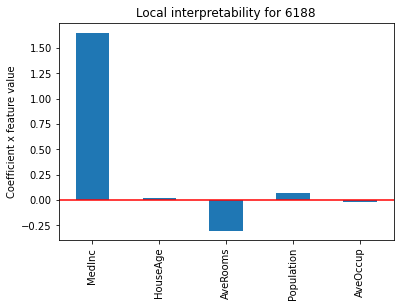

In [10]:
effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Coefficient x feature value")
plt.title(f"Local interpretability for {obs}")
plt.show()

In [11]:
# prediction of the observation being explained

preds[obs]

1.6341900412769241

## SHAP manual

We'll calculate the SHAP values manually as we discussed in the video.

In [12]:
# the mean value of each variable across the training set

X_train.mean()

MedInc        0.232188
HouseAge      0.541543
AveRooms      0.034759
Population    0.039860
AveOccup      0.003824
dtype: float64

In [13]:
# the expected (mean) effect for each variable

coeffs * X_train.mean()

MedInc        1.525450
HouseAge      0.477057
AveRooms     -0.172649
Population    0.033170
AveOccup     -0.013929
dtype: float64

In [14]:
# the shap value for each variable: how much the feature
# contributes to the prediction respect to the mean effect

effect - coeffs * X_train.mean()

MedInc        0.123210
HouseAge     -0.459784
AveRooms     -0.128162
Population    0.032673
AveOccup     -0.001993
dtype: float64

## SHAP

We'll now use the SHAP library.

In [15]:
explainer = shap.LinearExplainer(linreg, X_train)

shap_values = explainer(X_test)

In [16]:
shap_values[obs]

.values =
array([ 0.12039244, -0.47172515, -0.12767778,  0.03473923, -0.00251017])

.base_values =
2.0809714707337523

.data =
array([0.25094137, 0.01960784, 0.06056066, 0.07912217, 0.00437137])

**Important**

The difference in the values that we see between the SHAP library and the manual calculation are due to the SHAP library using **only 100 values** from the training set by default to estimate the expected mean effect.

See this [stackoverflow thread](https://stackoverflow.com/questions/78796974/shap-values-for-linear-model-different-from-those-calculated-manually) for more details. That is true for SHAP version 0.46.0.

To override this behaviour, we need to set up the explainer like this:

In [17]:
explainer = shap.LinearExplainer(
    linreg,
    shap.maskers.Independent(X_train, max_samples=len(X_train)),
)

shap_values = explainer(X_test)
shap_values[obs]

.values =
array([ 0.12321002, -0.45978436, -0.12816162,  0.03267303, -0.00199327])

.base_values =
2.0682462451550387

.data =
array([0.25094137, 0.01960784, 0.06056066, 0.07912217, 0.00437137])

In [18]:
# the mean feature value in training set calculated by shap

explainer.masker.data.mean(0)

array([0.23218765, 0.54154317, 0.03475851, 0.03985979, 0.00382413])

In [19]:
# the mean feature value calculated manually

X_train.mean()

MedInc        0.232188
HouseAge      0.541543
AveRooms      0.034759
Population    0.039860
AveOccup      0.003824
dtype: float64

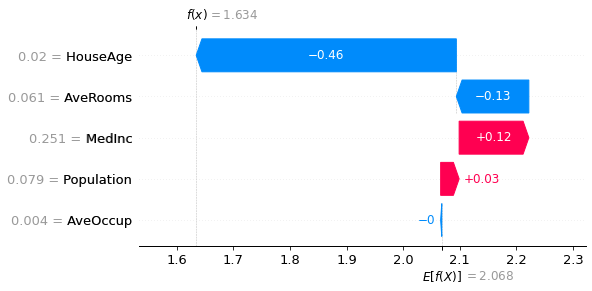

In [20]:
shap.plots.waterfall(shap_values[obs])

In [21]:
# it is not considering feature interactions
# these explanations are true to the model

explainer.feature_perturbation

'interventional'

In [22]:
# parameters extracted from the linear model

explainer.intercept

0.2191467343489466

In [23]:
# parameters extracted from the linear model

explainer.coef

array([ 6.56990021,  0.8809221 , -4.96709131,  0.83217128, -3.64240511])

## The SHAP value is linear

As the value of the variable increases, the SHAP value should increase or decrease linearly because this is a linear model.

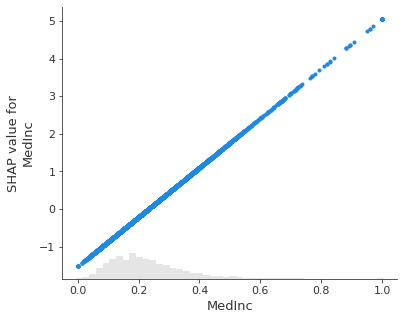

In [24]:
shap.plots.scatter(shap_values[:, 'MedInc'])

## Playground to compare other observations

Change the value in obs and see how the values calculated by SHAP compare with the manual values.

In [25]:
obs = 10

In [26]:
shap_values[obs]

.values =
array([-0.24166361,  0.23113493,  0.02767187, -0.01786973,  0.00526386])

.base_values =
2.0682462451550387

.data =
array([0.1954042 , 0.80392157, 0.02918747, 0.01838617, 0.00237897])

In [27]:
coeffs * X_test.loc[obs] - coeffs * X_train.mean()

MedInc       -0.241664
HouseAge      0.231135
AveRooms      0.027672
Population   -0.017870
AveOccup      0.005264
dtype: float64